In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from sklearn.metrics import accuracy_score

import requests, zipfile, io, json
import os, glob
import shutil

from datetime import datetime


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

print(tf.__version__)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2.9.1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
data_dir = './data/pollution/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

url='https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'
with requests.get(url) as data:
    data.raise_for_status()
    with open(os.path.join(data_dir, 'pollution.csv'), 'wt') as file:
        file.write(data.text)

            
print(os.listdir(data_dir))

['pollution.csv']


In [3]:
df = pd.read_csv(os.path.join(data_dir, 'pollution.csv'))
df['date'] = pd.to_datetime(df[['year','month','day', 'hour']])
df.drop(['No', 'year','month','day', 'hour'], axis=1, inplace=True)
df.set_index('date', inplace=True)
display(df.head())

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  41757 non-null  float64
 1   dew        43824 non-null  int64  
 2   temp       43824 non-null  float64
 3   press      43824 non-null  float64
 4   wnd_dir    43824 non-null  object 
 5   wnd_spd    43824 non-null  float64
 6   snow       43824 non-null  int64  
 7   rain       43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


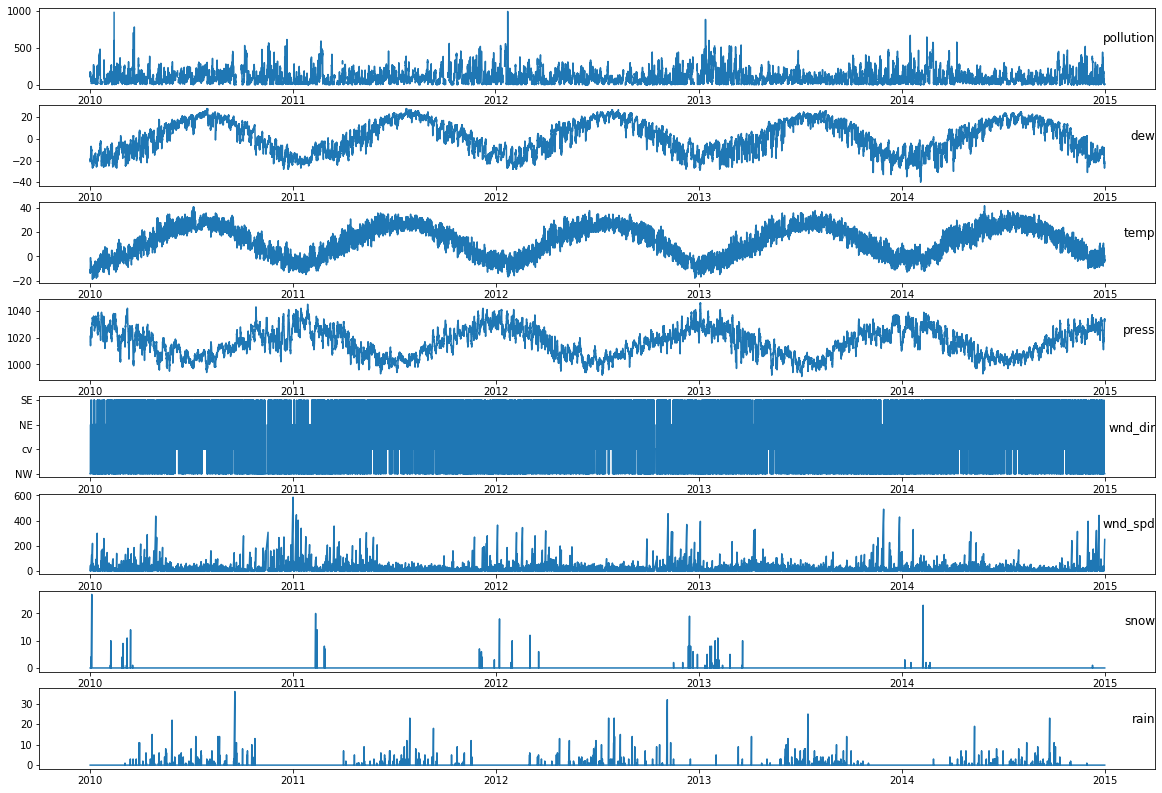

In [5]:
plt.figure(figsize=(20, 14))
for group in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, group+1)
    plt.plot(df.iloc[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
plt.show()

In [46]:
def time_series_to_supervised(data, n_lag=1, n_fut=1, selLag=None, selFut=None, dropnan=True):
    """
    Converts a time series to a supervised learning data set by adding time-shifted prior and future period
    data as input or output (i.e., target result) columns for each period
    :param data:  a series of periodic attributes as a list or NumPy array
    :param n_lag: number of PRIOR periods to lag as input (X); generates: Xa(t-1), Xa(t-2); min= 0 --> nothing lagged
    :param n_fut: number of FUTURE periods to add as target output (y); generates Yout(t+1); min= 0 --> no future periods
    :param selLag:  only copy these specific PRIOR period attributes; default= None; EX: ['Xa', 'Xb' ]
    :param selFut:  only copy these specific FUTURE period attributes; default= None; EX: ['rslt', 'xx']
    :param dropnan: True= drop rows with NaN values; default= True
    :return: a Pandas DataFrame of time series data organized for supervised learning
    NOTES:
    (1) The current period's data is always included in the output.
    (2) A suffix is added to the original column names to indicate a relative time reference: e.g., (t) is the current
        period; (t-2) is from two periods in the past; (t+1) is from the next period
    (3) This is an extension of Jason Brownlee's series_to_supervised() function, customized for MFI use
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    origNames = df.columns
    cols, names = list(), list()
    
    # lag any past period attributes (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # force valid number of lag periods
    for i in range(n_lag, 0, -1):
        suffix= '(t-%d)' % i
        if (None == selLag):   # copy all attributes from PRIOR periods?
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in (selLag):
                cols.append(df[var].shift(i))
                names+= [('%s%s' % (var, suffix))]
    
    # include all current period attributes (t-0) 
    cols.append(df.shift(0))
    names += [('%s(t-0)' % origNames[j]) for j in range(n_vars)]
    
    # include future period attributes (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # force valid number of future periods to shift back
    for i in range(1, n_fut + 1):
        suffix= '(t+%d)' % i
        if (None == selFut):  # copy all attributes from future periods?
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copy only selected future attributes
            for var in (selFut):
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]
    # combine everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values introduced by lagging
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def plot_series(time, series, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [22]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [37]:
df1 = df.copy().reset_index()

scalers = {} 
for col in df1.columns:
    if col not in ['wnd_dir', 'date']:
        scaler = MinMaxScaler()
        df1[col] = scaler.fit_transform(df1[[col]])
        scalers[col] = scaler



lbeb_encoder = LabelBinarizer() # sparse=False
temp_ = pd.DataFrame(
    lbeb_encoder.fit_transform(df1[['wnd_dir']]), 
    columns=[f'wnd_dir_{i}' for i in lbeb_encoder.classes_]
)
df1 = pd.concat([df1, temp_], axis=1).drop(['wnd_dir'], axis=1).set_index('date')

df1 = df1.drop(df1[df1.pollution.isnull()].index, axis=0)
df1 = df1.astype('float32')

display(df1.head())

,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
date,,,,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.0,1.0,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0


In [122]:
# frame as supervised learning
reframed = time_series_to_supervised(df1, 0, 1, selFut=['pollution'])
reframed.head()

,pollution(t-0),dew(t-0),temp(t-0),press(t-0),wnd_spd(t-0),snow(t-0),rain(t-0),wnd_dir_NE(t-0),wnd_dir_NW(t-0),wnd_dir_SE(t-0),wnd_dir_cv(t-0),pollution(t+1)
date,,,,,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.0,1.0,0.0,0.148893
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0,0.159960
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0,0.182093
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.138833
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.109658


In [45]:
# TODO
# Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
# Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.

# TODO
# Making all series stationary with differencing and seasonal adjustment.
# Providing more than 1 hour of input time steps.

In [123]:
def dataframe_splitter(data, test_ratio=0.2, train_size=None):
    if train_size is None:
        total = len(series)
        train_size = int(total - (total * test_ratio))
    train_data = data.iloc[:train_size, :]
    test_data = data.iloc[train_size:, :]
    return train_size, train_data.squeeze(), test_data.squeeze()

In [134]:
# WINDOW_SIZE = 20
BATCH_SIZE = 32
BUFFER_SIZE = 10000

PATIENCE = 5
MONITOR = 'val_loss'
SPLIT_RATIO = 0.2

n_train_hours = 365 * 24 * 4
_, xtrain, xtest = dataframe_splitter(reframed.drop('pollution(t+1)', axis=1), train_size=n_train_hours)
_, ytrain, ytest = dataframe_splitter(reframed[['pollution(t+1)']], train_size=n_train_hours)
xtrain = np.expand_dims(xtrain, axis=1)
xtest = np.expand_dims(xtest, axis=1)
print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

xtrain = tf.data.Dataset.from_tensor_slices(xtrain)
ytrain =  tf.data.Dataset.from_tensor_slices(ytrain)
print(xtrain, ytrain)

train_dataset = tf.data.Dataset.zip((xtrain, ytrain)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(train_dataset)

xtest = tf.data.Dataset.from_tensor_slices(xtest)
ytest =  tf.data.Dataset.from_tensor_slices(ytest)
print(xtest, ytest)

test_dataset = tf.data.Dataset.zip((xtest, ytest)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(test_dataset)

# Print shapes of feature and label
for window in train_dataset.take(1):
    print(f'shape of feature: {window[0].shape}')
    print(f'shape of label: {window[1].shape}')

(35040, 1, 11) (35040,) (6716, 1, 11) (6716,)
<TensorSliceDataset element_spec=TensorSpec(shape=(1, 11), dtype=tf.float32, name=None)> <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<TensorSliceDataset element_spec=TensorSpec(shape=(1, 11), dtype=tf.float32, name=None)> <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
shape of feature: (32, 1, 11)
shape of label: (32,)


In [ ]:
MODEL_NAME = './models/AirPollutionForecasting_full_verse.h5'
tf.keras.backend.clear_session()
callbacks = [tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))]
# callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-7)]
# callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
# callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=int(PATIENCE**1.5 if PATIENCE > 5 else PATIENCE**2), restore_best_weights=True)]

# Build the Model
model = tf.keras.models.Sequential([
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW_SIZE])
    # tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="tanh", input_shape=[WINDOW_SIZE, 1]),
    # tf.keras.layers.Input(shape=(xtrain.shape[-2], xtrain.shape[-1])),
    tf.keras.layers.Input(shape=(None, 11)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, )),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    # tf.keras.layers.Lambda(lambda x: x * 400.0)
])

# Setup the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['mae', 'mse']#, tf.keras.losses.Huber(), tf.keras.metrics.RootMeanSquaredError()]
)

# Print the model summary
print(model.summary())

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

Minimum achived loss was: 80
Best Learning Rate is: 1e-04


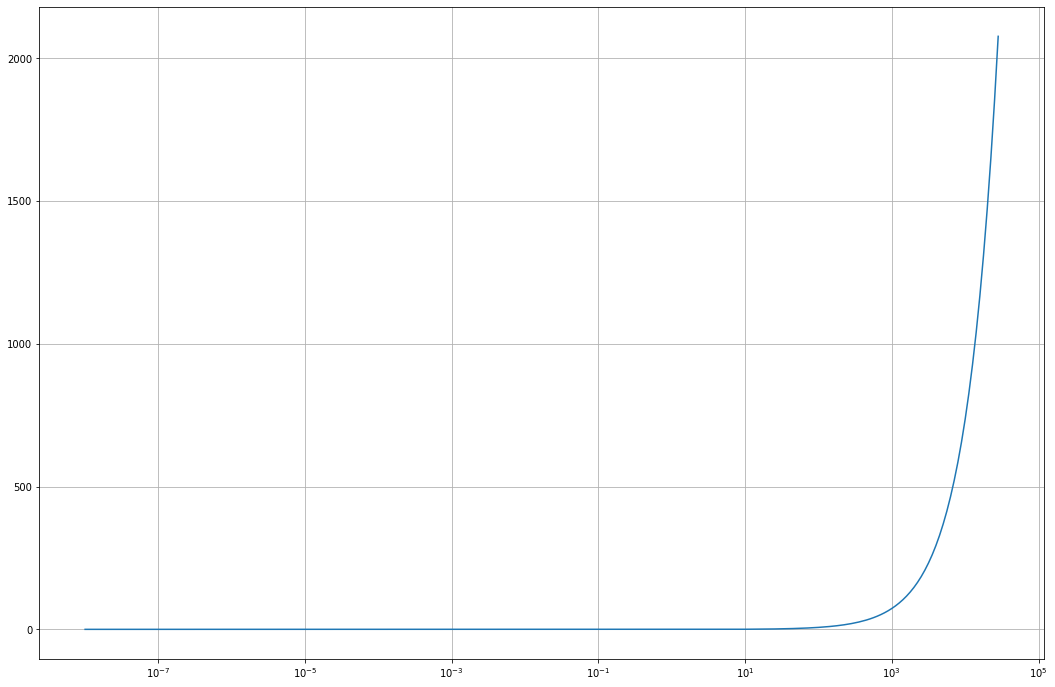

In [138]:
# Set the figure size
plt.figure(figsize=(18, 12))
# Set the grid
plt.grid(True)

print('Minimum achived loss was:', np.argmin(history.history['loss']))
print('Best Learning Rate is:', history.history['lr'][np.argmin(history.history['loss'])])
# Plot the loss in log scale
plt.semilogx(history.history['lr'], history.history["loss"])

In [ ]:
MODEL_NAME = './models/AirPollutionForecasting_32-1-11-1_full_verse.h5'
tf.keras.backend.clear_session()
# callbacks = [tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))]
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-7)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=int(PATIENCE**1.5 if PATIENCE > 5 else PATIENCE**2), restore_best_weights=True)]

# Build the Model
model = tf.keras.models.Sequential([
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW_SIZE])
    # tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="tanh", input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.Input(shape=(None, 11)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    # tf.keras.layers.Lambda(lambda x: x * 400.0)
])

# Setup the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Nadam(1e-4),
    metrics=['mae', 'mse']#, tf.keras.losses.Huber(), tf.keras.metrics.RootMeanSquaredError()]
)

# Print the model summary
print(model.summary())

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

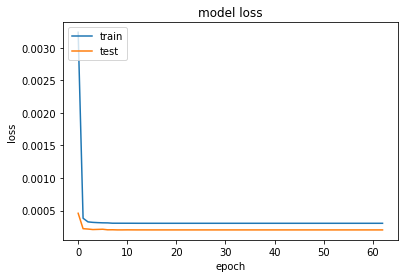

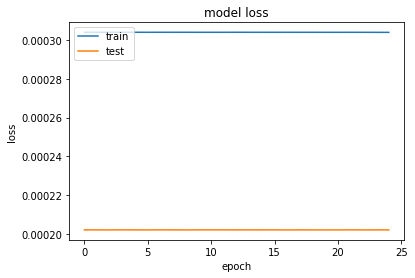

In [140]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][-25:])
plt.plot(history.history['val_loss'][-25:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [142]:
# forecast_dataset = windowed_dataset(series[1:split_time + WINDOW_SIZE], WINDOW_SIZE, BATCH_SIZE, mode='pred')

# results = model.predict(forecast_dataset).squeeze()

# # Compute the MSE and MAE
# print(tf.keras.metrics.mean_squared_error(x_train, results).numpy())
# print(tf.keras.metrics.mean_absolute_error(x_train, results).numpy())

# # Plot the results
# # plot_series(time_valid, (x_valid, results))
# plot_series(time_train, (x_train, results))

1095/1095 [==============================] - 4s 4ms/step


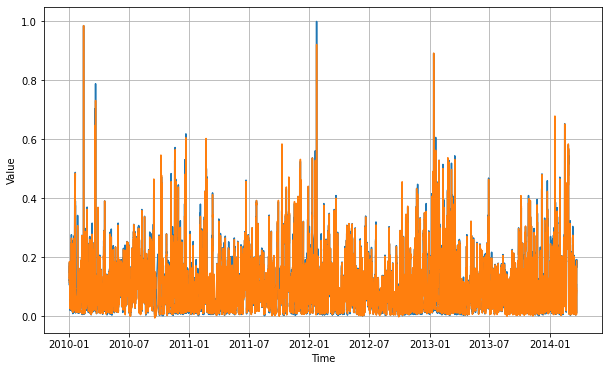

0.000608
0.013504


In [180]:
_, xtrain, xtest = dataframe_splitter(reframed.drop('pollution(t+1)', axis=1), train_size=n_train_hours)
_, ytrain, ytest = dataframe_splitter(reframed[['pollution(t+1)']], train_size=n_train_hours)
xtrain = np.expand_dims(xtrain, axis=1)
xtest = np.expand_dims(xtest, axis=1)

yhat = model.predict(xtrain)

plot_series(reframed.iloc[:-len(xtest)].index, (ytrain, yhat))

print(tf.keras.metrics.mean_squared_error(ytrain, yhat.squeeze()).numpy())
print(tf.keras.metrics.mean_absolute_error(ytrain, yhat.squeeze()).numpy())

# WE SHOULD INVERSE TRANSFORM THE VALUES TO SEE THE ACTUAL STUFF

# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

210/210 [==============================] - 1s 4ms/step


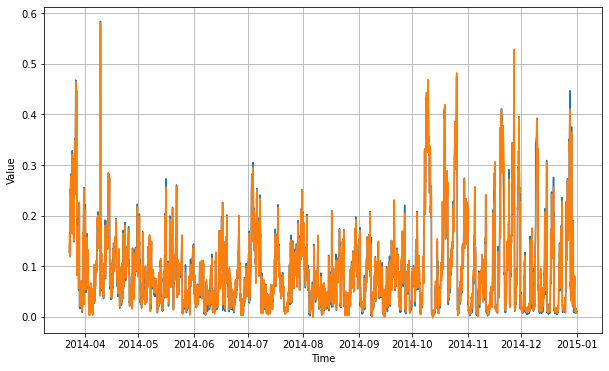

0.0004044
0.01136


In [181]:
yhat = model.predict(xtest)

plot_series(reframed.iloc[-len(xtest):].index, (ytest, yhat))

print(tf.keras.metrics.mean_squared_error(ytest, yhat.squeeze()).numpy())
print(tf.keras.metrics.mean_absolute_error(ytest, yhat.squeeze()).numpy())

In [218]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EPOCHS = 200
PATIENCE = 5
MONITOR = 'val_loss'
SPLIT_RATIO = 0.2

n_hours = 3
n_features = 11

reframed = time_series_to_supervised(df1, n_hours, 1, selFut=['pollution'])
display(reframed.head())

n_train_hours = 365 * 24 * 4
_, x_train, x_test = dataframe_splitter(reframed.drop('pollution(t+1)', axis=1), train_size=n_train_hours)
_, y_train, y_test = dataframe_splitter(reframed[['pollution(t+1)']], train_size=n_train_hours)

x_train = np.array(x_train).reshape([x_train.shape[0], n_hours+1, n_features])
x_test = np.array(x_test).reshape([x_test.shape[0], n_hours+1, n_features])
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

xtrain = tf.data.Dataset.from_tensor_slices(x_train)
ytrain =  tf.data.Dataset.from_tensor_slices(y_train)
print(xtrain, ytrain)

train_dataset = tf.data.Dataset.zip((xtrain, ytrain)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(train_dataset)

xtest = tf.data.Dataset.from_tensor_slices(x_test)
ytest =  tf.data.Dataset.from_tensor_slices(y_test)
print(xtest, ytest)

test_dataset = tf.data.Dataset.zip((xtest, ytest)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(test_dataset)

# Print shapes of feature and label
for window in train_dataset.take(1):
    print(f'shape of feature: {window[0].shape}')
    print(f'shape of label: {window[1].shape}')

,pollution(t-3),dew(t-3),temp(t-3),press(t-3),wnd_spd(t-3),snow(t-3),rain(t-3),wnd_dir_NE(t-3),wnd_dir_NW(t-3),wnd_dir_SE(t-3),...,temp(t-0),press(t-0),wnd_spd(t-0),snow(t-0),rain(t-0),wnd_dir_NE(t-0),wnd_dir_NW(t-0),wnd_dir_SE(t-0),wnd_dir_cv(t-0),pollution(t+1)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-02 03:00:00,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.0,1.0,...,0.229508,0.563636,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.138833
2010-01-02 04:00:00,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,...,0.229508,0.563636,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.109658
2010-01-02 05:00:00,0.159960,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.0,0.0,1.0,...,0.213115,0.563636,0.011433,0.111111,0.0,0.0,0.0,1.0,0.0,0.105634
2010-01-02 06:00:00,0.182093,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.0,0.0,1.0,...,0.213115,0.581818,0.014492,0.148148,0.0,0.0,0.0,1.0,0.0,0.124748
2010-01-02 07:00:00,0.138833,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.0,0.0,1.0,...,0.229508,0.600000,0.017551,0.000000,0.0,0.0,0.0,1.0,0.0,0.120724


(35040, 4, 11) (35040,) (6713, 4, 11) (6713,)
<TensorSliceDataset element_spec=TensorSpec(shape=(4, 11), dtype=tf.float32, name=None)> <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 4, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<TensorSliceDataset element_spec=TensorSpec(shape=(4, 11), dtype=tf.float32, name=None)> <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 4, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
shape of feature: (64, 4, 11)
shape of label: (64,)


In [ ]:
MODEL_NAME = './models/AirPollutionForecasting_64-4-11-1_full_verse.h5'
tf.keras.backend.clear_session()
callbacks = [tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))]
# callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-7)]
# callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
# callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=int(PATIENCE**1.5 if PATIENCE > 5 else PATIENCE**2), restore_best_weights=True)]

# Build the Model
model = tf.keras.models.Sequential([
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW_SIZE])
    # tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="tanh", input_shape=[WINDOW_SIZE, 1]),
    # tf.keras.layers.Input(shape=(xtrain.shape[-2], xtrain.shape[-1])),
    tf.keras.layers.Input(shape=(None, 11)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, )),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    # tf.keras.layers.Lambda(lambda x: x * 400.0)
])

# Setup the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['mae', 'mse']#, tf.keras.losses.Huber(), tf.keras.metrics.RootMeanSquaredError()]
)

# Print the model summary
print(model.summary())

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

Minimum achived loss was: 110
Best Learning Rate is: 0.0031622776


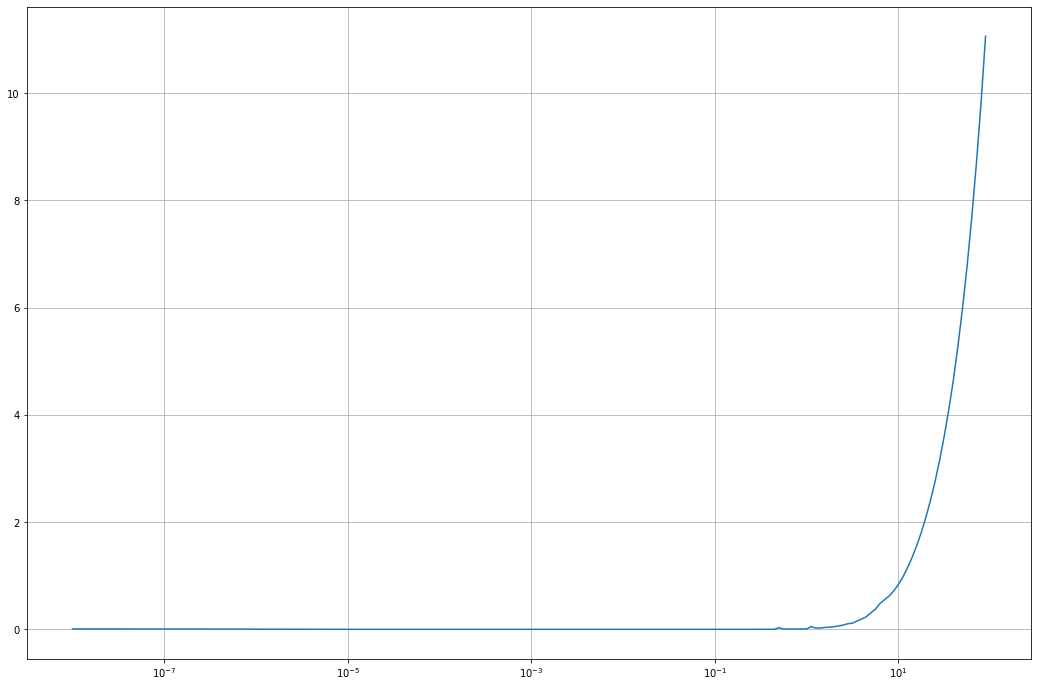

In [221]:
# Set the figure size
plt.figure(figsize=(18, 12))
# Set the grid
plt.grid(True)

print('Minimum achived loss was:', np.argmin(history.history['loss']))
print('Best Learning Rate is:', history.history['lr'][np.argmin(history.history['loss'])])
# Plot the loss in log scale
plt.semilogx(history.history['lr'], history.history["loss"])

In [ ]:
MODEL_NAME = './models/AirPollutionForecasting_64-4-11-1_full_verse.h5'
tf.keras.backend.clear_session()
# callbacks = [tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))]
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-7)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=int(PATIENCE**1.5 if PATIENCE > 5 else PATIENCE**2), restore_best_weights=True)]

# Build the Model
model = tf.keras.models.Sequential([
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW_SIZE])
    # tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="tanh", input_shape=[WINDOW_SIZE, 1]),
    # tf.keras.layers.Input(shape=(xtrain.shape[-2], xtrain.shape[-1])),
    tf.keras.layers.Input(shape=(None, 11)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, )),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    # tf.keras.layers.Lambda(lambda x: x * 400.0)
])

# Setup the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Nadam(3e-3),
    metrics=['mae', 'mse']#, tf.keras.losses.Huber(), tf.keras.metrics.RootMeanSquaredError()]
)

# Print the model summary
print(model.summary())

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

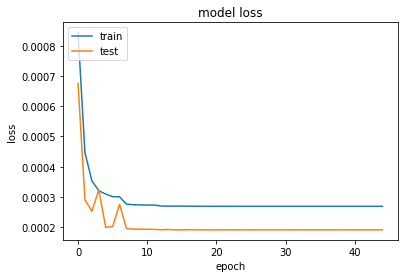

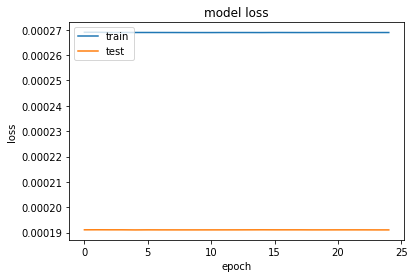

In [224]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][-25:])
plt.plot(history.history['val_loss'][-25:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1095/1095 [==============================] - 7s 5ms/step


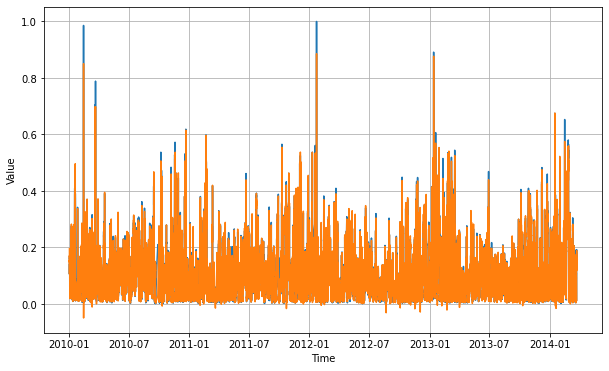

0.000538
0.01277
210/210 [==============================] - 3s 6ms/step


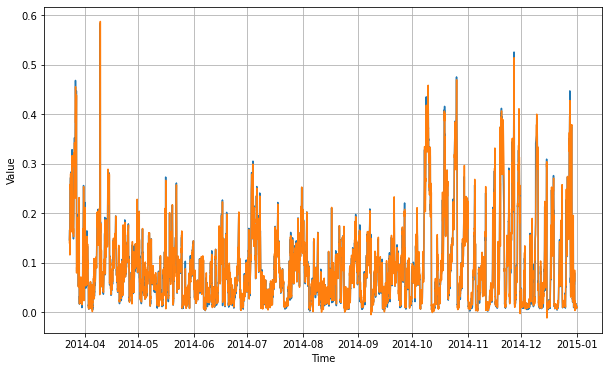

0.0003817
0.010796


In [227]:
_, xtrain, xtest = dataframe_splitter(reframed.drop('pollution(t+1)', axis=1), train_size=n_train_hours)
_, ytrain, ytest = dataframe_splitter(reframed[['pollution(t+1)']], train_size=n_train_hours)


xtrain = np.array(xtrain).reshape([xtrain.shape[0], n_hours+1, n_features])
xtest = np.array(xtest).reshape([xtest.shape[0], n_hours+1, n_features])

yhat = model.predict(xtrain)

plot_series(reframed.iloc[:-len(xtest)].index, (ytrain, yhat))

print(tf.keras.metrics.mean_squared_error(ytrain, yhat.squeeze()).numpy())
print(tf.keras.metrics.mean_absolute_error(ytrain, yhat.squeeze()).numpy())

yhat = model.predict(xtest)

plot_series(reframed.iloc[-len(xtest):].index, (ytest, yhat))

print(tf.keras.metrics.mean_squared_error(ytest, yhat.squeeze()).numpy())
print(tf.keras.metrics.mean_absolute_error(ytest, yhat.squeeze()).numpy())